In [1]:
# Load libs:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task

from amplify.data import DataGenerator, DataSplit

In [2]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="predict_power_gen_initial_model_ss")

ClearML Task: created new task id=a5c3e45565aa4fe299055d4ed7a2fee0
2022-01-31 06:03:37,803 - clearml.Task - WARNING - Failed auto-detecting task repository: Script file ['ipykernel_launcher', '/tmp/ipykernel_60014/1588979629.py'] could not be found
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/a5c3e45565aa4fe299055d4ed7a2fee0/output/log


## Load Data

In [3]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.head()

Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Successfully merged Building and Weather data!
Successfully added Azimuth and Irradiance data!


,temp,clouds_all,azimuth,irradiance,day_of_week,True Power (kW) solar,True Power (kW) usage
2021-10-19 04:00:00+00:00,11.18,75.0,338.24,0.0,2,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,20.0,7.14,0.0,2,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,20.0,34.06,0.0,2,1.0,12.7
2021-10-19 07:00:00+00:00,9.28,20.0,54.27,0.0,2,1.0,17.2
2021-10-19 08:00:00+00:00,9.28,20.0,69.01,0.0,2,1.0,17.0


In [4]:
# What is the shape of the data?
print(f"XY Data Shape: {xy_data.shape}")

XY Data Shape: (1994, 7)


In [5]:
# Lets see a few more rows
xy_data.head(20)

,temp,clouds_all,azimuth,irradiance,day_of_week,True Power (kW) solar,True Power (kW) usage
2021-10-19 04:00:00+00:00,11.18,75.0,338.24,0.00,2,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,20.0,7.14,0.00,2,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,20.0,34.06,0.00,2,1.0,12.7
2021-10-19 07:00:00+00:00,9.28,20.0,54.27,0.00,2,1.0,17.2
2021-10-19 08:00:00+00:00,9.28,20.0,69.01,0.00,2,1.0,17.0
2021-10-19 09:00:00+00:00,8.91,1.0,80.59,0.00,2,1.0,14.2
2021-10-19 10:00:00+00:00,8.61,1.0,90.61,0.00,2,1.0,14.4
2021-10-19 11:00:00+00:00,8.97,1.0,100.11,0.00,2,1.0,14.1
2021-10-19 12:00:00+00:00,9.12,1.0,109.88,323.34,2,11.3,12.5
2021-10-19 13:00:00+00:00,10.96,1.0,120.65,680.92,2,24.9,13.7


In [6]:
# timestamp example
xy_data.index[0]

Timestamp('2021-10-19 04:00:00+0000', tz='UTC', freq='H')

## Data Processing

```
1. Make xy data into a set of series of shape [N, M, F],
where N = number of examples; M = nubmer of timestamps; F = Number of features
```

```
2. Train-Test-Validation Split. Split off at 0.8, 0.1, 0.1 ratio for now. Shuffle the split.
```

```
3. Seperate x, y from dataset. Remove last column from dataset to extract y.
```

In [7]:
# Data Split parameters 
SERIES = 48
STRIDE = 1


In [8]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

# |0| |2|3| |5|6|7|8|9|
#    T     V 

# This is for solar only, for now
train_ds, val_ds, test_ds = DataSplit(xy_data, series_length=SERIES, stride=STRIDE, shuffle=False).split_data()

In [9]:
# Isolate XY from datasets
x_train, y_train,  = (
    train_ds[0],
    train_ds[1],
)  # Training data
x_val, y_val = (
    val_ds[0],
    val_ds[1],
)  # Validation data
x_test, y_test = (
    test_ds[0],
    test_ds[1],
)  # Test data


In [10]:
# format data for training...
# [1,2,....] <= was a column
# do we do (n, 1, n timesteps, n features per timestep) (3,4,5 => 2 days)?

### Reviewing Data

In [11]:
# x_train shape
print("x_train shape")
x_train.shape

x_train shape


(1556, 48, 5)

In [12]:
# y_train shape
print("y_solar_train shape")
y_train.shape

y_solar_train shape


(1556, 48, 2)

## Modeling

In [13]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, Normalization, TimeDistributed

### Normalize Data

## Encoder/Decoder LSTM

In [14]:
# Normalize to x_train data
norm_layer = Normalization(axis=-1)
norm_layer.adapt(x_train)

# Define the model 
norm_inputs = Input(shape=(SERIES, x_train.shape[-1]))
encoder_inputs = norm_layer(norm_inputs)
encoder_l1 = LSTM(2*SERIES, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = RepeatVector(SERIES)(encoder_outputs1[0])

decoder_l1 = LSTM(2*SERIES, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(Dense(y_train.shape[-1]))(decoder_l1)

model = Model(norm_inputs, decoder_outputs1)

2022-01-31 06:04:34.082182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 06:04:34.088230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 06:04:34.088887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 06:04:34.090659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 5)]      0           []                               
                                                                                                  
 normalization (Normalization)  (None, 48, 5)        11          ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 96),         39168       ['normalization[0][0]']          
                                 (None, 96),                                                      
                                 (None, 96)]                                                      
                                                                                              

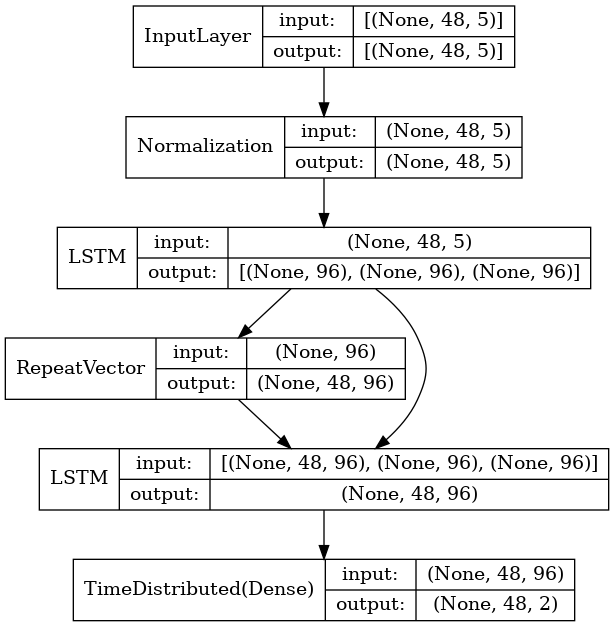

In [15]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [16]:
# Hyperparameters and callbacks

BATCH  = 10
EPOCHS = 100
FACTOR = .1
PATIENCE = 10

callbacks = [
    tf.keras.callbacks.TensorBoard('../logs/', histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(
        "../models/lstm_weights.hdf5", 
        monitor="val_loss",
        mode='min',
        save_best_only=True, 
        save_weights_only=True, 
        verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        mode='min', 
        factor=FACTOR,
        patience=PATIENCE, 
        min_lr=1e-8, 
        verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode='min', 
        patience=3*PATIENCE, 
        verbose=1)
]

In [17]:
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)


Epoch 1/100


2022-01-31 06:04:38.832440: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


156/156 [==============================] - 8s 30ms/step - loss: 5.5408 - root_mean_squared_error: 9.6254 - val_loss: 3.3526 - val_root_mean_squared_error: 6.0114 - lr: 0.0010
Epoch 2/100
156/156 [==============================] - 3s 22ms/step - loss: 4.6335 - root_mean_squared_error: 8.6771 - val_loss: 3.3216 - val_root_mean_squared_error: 6.0362 - lr: 0.0010
Epoch 3/100
156/156 [==============================] - 4s 23ms/step - loss: 4.6210 - root_mean_squared_error: 8.6501 - val_loss: 3.3023 - val_root_mean_squared_error: 6.0133 - lr: 0.0010
Epoch 4/100
156/156 [==============================] - 3s 21ms/step - loss: 4.5929 - root_mean_squared_error: 8.6052 - val_loss: 3.2132 - val_root_mean_squared_error: 6.0586 - lr: 0.0010
Epoch 5/100
156/156 [==============================] - 2s 10ms/step - loss: 4.5434 - root_mean_squared_error: 8.4873 - val_loss: 3.3268 - val_root_mean_squared_error: 5.9057 - lr: 0.0010
Epoch 6/100
156/156 [==============================] - 3s 21ms/step - loss: 4

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


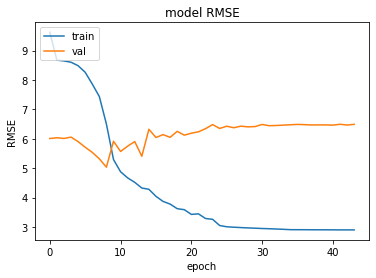

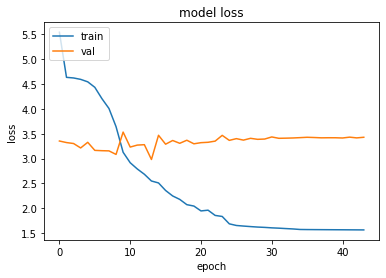

In [18]:
def plot_history(history, metric):
    # This function will plot the model fit process
    print(history.history.keys())
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history, 'root_mean_squared_error')

In [19]:
#Make Predictions
model.load_weights("../models/lstm_weights.hdf5")
y_preds = model.predict(x_test, verbose=1, batch_size=1, callbacks=callbacks)


195/195 [==============================] - 1s 2ms/step


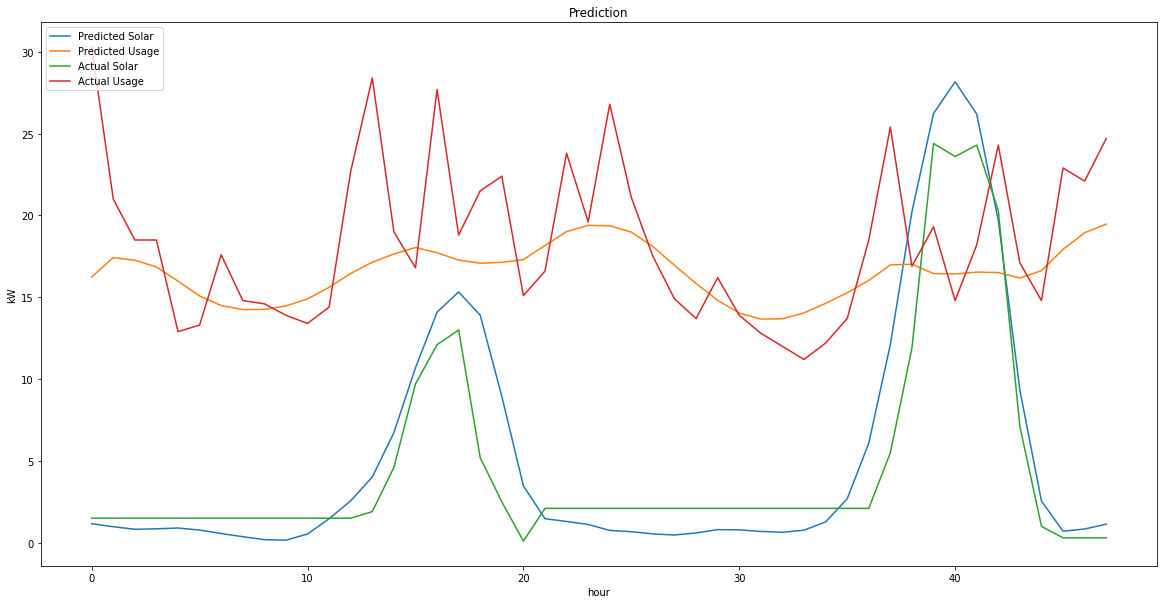

In [30]:
plt.figure(figsize=(20, 10))
plt.title('Prediction')
x = np.random.default_rng().integers(0, y_preds.shape[0])
plt.plot(y_preds[x,:,:])
plt.plot(y_test[x,:,:])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['Predicted Solar', 'Predicted Usage', 'Actual Solar', 'Actual Usage'], loc='upper left')

plt.show()